# Imports

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, "..")
from league_data import LeagueData

2025-06-02 06:24:03.429 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-06-02 06:24:03.430 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-06-02 06:24:03.430 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-06-02 06:24:03.431 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-06-02 06:24:03.431 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-06-02 06:24:03.432 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-06-02 06:24:03.432 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


# Definitions

In [7]:
leagueID = 1185122
standings_url_template = (
    "https://fantasy.premierleague.com/api/leagues-classic/{leagueID}/standings/"
)
history_url_template = (
    "https://fantasy.premierleague.com/api/entry/{manager_id}/history/"
)
picks_url_template = (
    "https://fantasy.premierleague.com/api/entry/{manager_id}/event/{gw}/picks/"
)
transfers_url_template = (
    "https://fantasy.premierleague.com/api/entry/{manager_id}/transfers/"
)
bootstrap_static_url = "https://fantasy.premierleague.com/api/bootstrap-static/"
live_url_template = "https://fantasy.premierleague.com/api/event/{gw}/live/"

# Functions

In [8]:
def std(x):
    return np.std(x)


def jaccard_sim(df):
    columns = df.columns
    jaccard_matrix = np.empty([len(columns), len(columns)])
    for i, row in enumerate(columns):
        for j, col in enumerate(columns):
            jaccard_sim = len(set(df[row]).intersection(set(df[col]))) / len(
                set(df[row]).union(set(df[col]))
            )
            jaccard_matrix[i, j] = jaccard_sim
    jaccard_sim_df = pd.DataFrame(index=columns, columns=columns, data=jaccard_matrix)
    return jaccard_sim_df

# Gaussian plot class

In [9]:
class Gaussian:
    @staticmethod
    def plot(
        mean,
        std,
        lower_bound=None,
        upper_bound=None,
        resolution=None,
        title=None,
        x_label=None,
        y_label=None,
        legend_label=None,
        legend_location="best",
    ):

        lower_bound = (mean - 4 * std) if lower_bound is None else lower_bound
        upper_bound = (mean + 4 * std) if upper_bound is None else upper_bound
        resolution = 100

        title = title or "Gaussian Distribution"
        x_label = x_label or "x"
        y_label = y_label or "N(x|μ,σ)"
        legend_label = legend_label or "μ={}, σ={}".format(mean, std)
        legend_label = None

        X = np.linspace(lower_bound, upper_bound, resolution)
        dist_X = Gaussian._distribution(X, mean, std)

        plt.title(title)

        plt.plot(X, dist_X, label=legend_label)

        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend(loc=legend_location)

        return plt

    @staticmethod
    def _distribution(X, mean, std):
        return (
            1.0
            / (np.sqrt(2 * np.pi) * std)
            * np.exp(-0.5 * (1.0 / std * (X - mean)) ** 2)
        )

# Define League Data Object

In [10]:
ldo = LeagueData(  # league data object
    leagueID=leagueID,  # type: ignore
    standings_url_template=standings_url_template,
    history_url_template=history_url_template,
    picks_url_template=picks_url_template,
    transfers_url_template=transfers_url_template,
    bootstrap_static_url=bootstrap_static_url,
    live_url_template=live_url_template,
)

2025-06-02 06:29:35.701 No runtime found, using MemoryCacheStorageManager
2025-06-02 06:29:42.317 No runtime found, using MemoryCacheStorageManager
2025-06-02 06:29:42.430 No runtime found, using MemoryCacheStorageManager
2025-06-02 06:34:20.760 No runtime found, using MemoryCacheStorageManager
2025-06-02 06:34:29.048 No runtime found, using MemoryCacheStorageManager


# Difficult award calculations

## Most diverse team

In [11]:
league_teams_df = ldo.league_teams_df.copy()
league_teams_df["player_pick"] = league_teams_df["player_pick"].str.replace(
    r"\(\S\)", "", regex=True
)
a = league_teams_df.groupby("player_pick")["Manager"].unique()
total_unique_player_counts = (
    pd.DataFrame.from_records(a.values.tolist()).stack().value_counts()
)
total_unique_player_counts

Dan Pratlett       86
Mason Gardener     75
Ben Melhuish       75
Ben Anderson       74
James Parfitt      72
Seb Winn           71
Joseph Parsons     71
Matthew Turner     67
Jacob Pickles      67
Alex Winn          65
Luke Counsell      62
Hailey Mayo        62
Ben Wilson         60
Richard Collins    48
Name: count, dtype: int64

<Axes: >

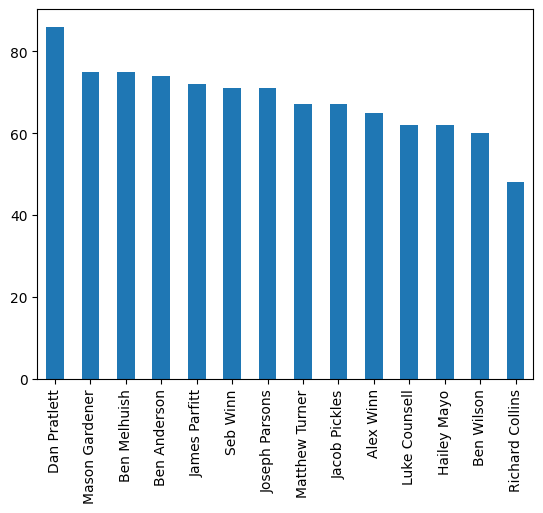

In [12]:
total_unique_player_counts.plot.bar(x="Manager")

## Mr. (in)consistent

In [13]:
points_spread_df = (
    ldo.season_stats_df.groupby("Manager")["Points"]
    .agg(["mean", "max", std])
    .sort_values(by=["std"], ascending=False)
)
points_spread_df

,mean,max,std
Manager,,,
Ben Wilson,57.763158,120,22.060246
Matthew Turner,65.684211,133,20.379434
Seb Winn,65.842105,127,20.351550
Hailey Mayo,61.605263,113,19.339814
Richard Collins,57.026316,113,19.234682
Mason Gardener,63.447368,112,18.769653
Jacob Pickles,59.657895,106,18.516389
Luke Counsell,64.157895,125,18.249047
Joseph Parsons,57.263158,107,17.857159


<Axes: xlabel='Manager'>

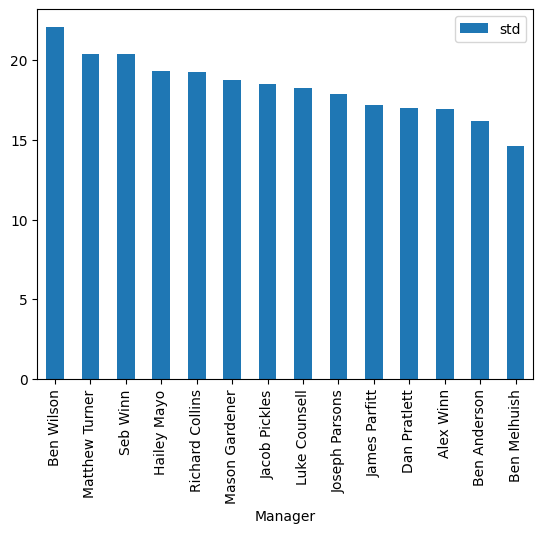

In [14]:
points_spread_df.plot.bar(y="std")

### Gaussian plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

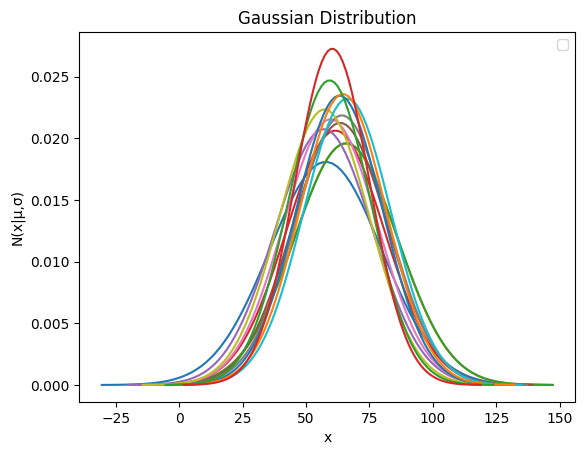

In [15]:
for manager in points_spread_df.index:
    mu = points_spread_df.loc[manager, "mean"]
    sigma = points_spread_df.loc[manager, "std"]
    plot = Gaussian.plot(mu, sigma)
plot.show()

## Saved by the bench

In [16]:
for i, (manager_id, manager_name) in enumerate(ldo.manager_id_name_dict.items()):
    print(manager_name)
    count = 0
    for j, gw in enumerate(range(1, ldo.max_gw + 1)):
        #print(gw)
        team_selection_response_json = ldo._get_requests_response(
            ldo.picks_url_template, manager_id=manager_id, gw=gw
        )
        if not team_selection_response_json["automatic_subs"]:
            continue
        auto_subs_df = pd.DataFrame(team_selection_response_json["automatic_subs"])
        count += 1
    print(count)

### Boringly, it's Luke

James Parfitt
8
Seb Winn
11
Matthew Turner
10
Alex Winn
13
Luke Counsell
10
Mason Gardener
15
Hailey Mayo
13
Dan Pratlett
18
Ben Melhuish
13
Jacob Pickles
12
Richard Collins
18
Ben Wilson
12
Ben Anderson
19
Joseph Parsons
8


## Anti rhino

In [17]:
### It's Ben Anderson

## Best ROI

In [18]:
season_stats_df = ldo.season_stats_df.copy()
season_stats_df["price_per_point"] = season_stats_df["Value"].div(
    season_stats_df["Points"]
)
roi_df = (
    season_stats_df.groupby("Manager")["price_per_point"]
    .agg(["mean", "max", std])
    .sort_values(by=["mean"], ascending=True)
)
roi_df

,mean,max,std
Manager,,,
James Parfitt,1.655157e+06,2.615000e+06,4.001991e+05
Alex Winn,1.679343e+06,2.673684e+06,3.808296e+05
Seb Winn,1.709364e+06,3.632143e+06,5.505108e+05
Matthew Turner,1.717328e+06,3.410000e+06,5.507132e+05
Luke Counsell,1.717570e+06,2.885714e+06,4.678937e+05
Dan Pratlett,1.748048e+06,2.612500e+06,4.507558e+05
Mason Gardener,1.751573e+06,3.465517e+06,5.546320e+05
Ben Melhuish,1.788489e+06,2.665789e+06,4.147409e+05
Hailey Mayo,1.842463e+06,3.953846e+06,6.444655e+05


<Axes: xlabel='Manager'>

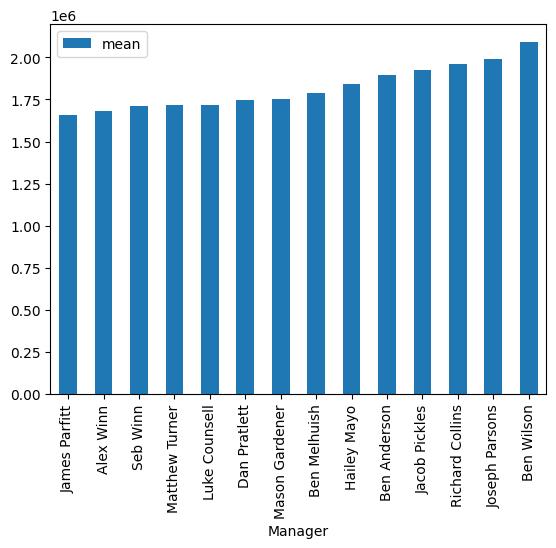

In [19]:
roi_df.plot.bar(y="mean")

## Last minute transfers

In [20]:
transfers_df = ldo.transfers_df.copy()
bootstrap_static_events_df = ldo.bootstrap_static_events_df.copy()

### Merge dataframes
merged_df = pd.merge(
    left=transfers_df,
    right=bootstrap_static_events_df.loc[:, ["id", "deadline_time"]],
    left_on=["GW"],
    right_on=["id"],
    how="outer",
)
### Convert to datetimes
merged_df["time"] = pd.to_datetime(merged_df["time"])
merged_df["deadline_time"] = pd.to_datetime(merged_df["deadline_time"])

### Find time difference
merged_df["time_before_deadline"] = merged_df["deadline_time"] - merged_df["time"]

### Groupby and mean
time_before_deadline_df = (
    merged_df.groupby("Manager")["time_before_deadline"]
    .agg(["mean", "max", std])
    .sort_values(by=["mean"], ascending=True)
)
time_before_deadline_df

,mean,max,std
Manager,,,
Richard Collins,0 days 07:21:56.509894435,1 days 00:12:25.651423,0 days 09:54:27.195750431
Matthew Turner,0 days 09:05:37.020289855,6 days 03:50:27.837481,0 days 18:17:28.439964035
Mason Gardener,0 days 11:37:48.058769586,3 days 00:55:14.541871,0 days 16:51:22.507755940
Joseph Parsons,0 days 12:00:14.956440040,3 days 21:57:17.959284,0 days 18:48:45.752401207
Ben Melhuish,0 days 14:46:49.544097682,4 days 01:46:38.460741,0 days 16:58:46.700623861
Hailey Mayo,0 days 14:53:13.217462781,6 days 14:25:55.352586,1 days 03:10:22.191375924
Alex Winn,1 days 05:01:06.128466419,8 days 02:49:45.930008,1 days 06:37:14.364370401
Seb Winn,1 days 16:54:48.287585916,6 days 13:13:03.549681,2 days 05:13:18.611805992
James Parfitt,1 days 17:47:03.523051841,12 days 12:33:44.903414,3 days 18:18:06.800908821


<Axes: xlabel='Manager'>

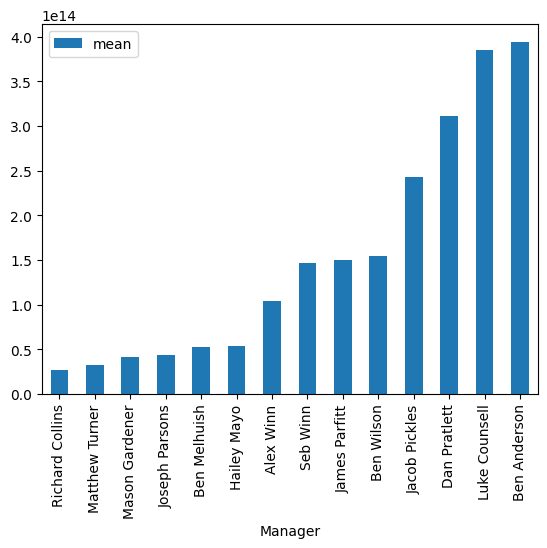

In [21]:
time_before_deadline_df.plot.bar(y="mean")

## Most points on bench

In [16]:
### Jacob Pickles: 382

## Highest transfer costs

In [17]:
## Dan Prattlet: 132

## Lowest highest rank

In [18]:
### Joe Parsons: 8

## Blandest team

In [22]:
league_picks_df = ldo.league_teams_df.assign(
    idx=ldo.league_teams_df.groupby("Manager").cumcount()
).pivot(index="idx", columns="Manager", values="player_pick_full")
gw_range = [1, 38]
gw_select_indx = list(range((gw_range[0] - 1) * 15, gw_range[1] * 15))
sim_df = jaccard_sim(league_picks_df.iloc[gw_select_indx])
overall_sim = sim_df.mean().sort_values(ascending=False)
overall_sim

Manager
James Parfitt      0.205676
Hailey Mayo        0.201576
Seb Winn           0.194268
Matthew Turner     0.192520
Alex Winn          0.189007
Luke Counsell      0.186915
Ben Melhuish       0.178190
Jacob Pickles      0.169249
Mason Gardener     0.168131
Richard Collins    0.164822
Joseph Parsons     0.164042
Dan Pratlett       0.164004
Ben Wilson         0.162851
Ben Anderson       0.161334
dtype: float64

<Axes: xlabel='Manager'>

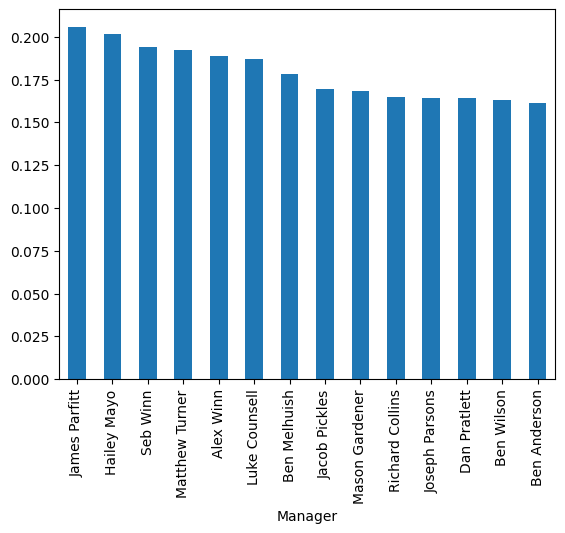

In [23]:
overall_sim.plot.bar()

## Points from player positions

In [24]:
league_teams_df = ldo.league_teams_df.copy()
player_points_merged_df = pd.merge(
    left=league_teams_df,
    right=ldo.players_df,
    left_on=["element", "player_name", "gw"],
    right_on=["player_id", "web_name", "gw"],
    how="inner",
)
player_points_merged_df["awarded_points"] = (
    player_points_merged_df["multiplier"] * player_points_merged_df["total_points"]
)

In [25]:
player_points_merged_df.loc[
    player_points_merged_df["Manager"] == "Richard Collins", :
].sort_values(["gw", "position"]).head(10)

,element,position,multiplier,is_captain,is_vice_captain,element_type,player_name,Manager,gw,status,player_pick,player_pick_full,player_id,web_name,total_points,awarded_points
5730,201,1,1,False,False,1,Henderson,Richard Collins,1,p,Henderson (p),Henderson (p)1,201,Henderson,2,2
5731,191,2,1,False,False,2,Andersen,Richard Collins,1,p,Andersen (p),Andersen (p)1,191,Andersen,0,0
5732,18,3,1,False,False,2,Saliba,Richard Collins,1,p,Saliba (p),Saliba (p)1,18,Saliba,6,6
5733,350,4,1,False,False,2,Gvardiol,Richard Collins,1,p,Gvardiol (p),Gvardiol (p)1,350,Gvardiol,7,7
5734,348,5,1,False,False,3,Foden,Richard Collins,1,p,Foden (p),Foden (p)1,348,Foden,1,1
5735,54,6,1,False,False,3,Rogers,Richard Collins,1,p,Rogers (p),Rogers (p)1,54,Rogers,2,2
5736,398,7,1,False,False,3,Gordon,Richard Collins,1,p,Gordon (p),Gordon (p)1,398,Gordon,3,3
5737,503,8,1,False,True,3,Son,Richard Collins,1,v,Son (v),Son (v)1,503,Son,2,2
5738,351,9,2,True,False,4,Haaland,Richard Collins,1,c,Haaland (c),Haaland (c)1,351,Haaland,7,14
5739,129,10,1,False,False,4,João Pedro,Richard Collins,1,p,João Pedro (p),João Pedro (p)1,129,João Pedro,2,2


### Loop and calc

In [26]:
managers = player_points_merged_df["Manager"].unique()
col_names = [
    "Manager",
    "awarded_points",
    "gk_points",
    "df_points",
    "gk_df_points",
    "mf_points",
    "fd_points",
    "c_points",
    "vc_points",
]
ppp_dict = {c: [] for c in col_names}
for manager in managers:
    ppp_dict["Manager"].append(manager)
    manager_df = player_points_merged_df.loc[
        player_points_merged_df["Manager"] == manager
    ]
    ppp_dict["awarded_points"].append(manager_df.loc[:, "awarded_points"].sum())
    ppp_dict["gk_points"].append(
        manager_df.loc[manager_df["position"].isin([1]), "awarded_points"].sum()
    )
    ppp_dict["df_points"].append(
        manager_df.loc[
            manager_df["position"].isin([2, 3, 4, 5]), "awarded_points"
        ].sum()
    )
    ppp_dict["gk_df_points"].append(
        manager_df.loc[
            manager_df["position"].isin([1, 2, 3, 4, 5]), "awarded_points"
        ].sum()
    )
    ppp_dict["mf_points"].append(
        manager_df.loc[
            manager_df["position"].isin([6, 7, 8, 9]), "awarded_points"
        ].sum()
    )
    ppp_dict["fd_points"].append(
        manager_df.loc[manager_df["position"].isin([10, 11]), "awarded_points"].sum()
    )
    ppp_dict["c_points"].append(
        manager_df.loc[manager_df["is_captain"] == True, "awarded_points"].sum()
    )
    ppp_dict["vc_points"].append(
        manager_df.loc[manager_df["is_vice_captain"] == True, "awarded_points"].sum()
    )
ppp_df = pd.DataFrame(ppp_dict)
for c in col_names[2:]:
    ppp_df[f"{c}_pc"] = ppp_df[c].div(ppp_df["awarded_points"]).mul(100)
ppp_df

,Manager,awarded_points,gk_points,df_points,gk_df_points,mf_points,fd_points,c_points,vc_points,gk_points_pc,df_points_pc,gk_df_points_pc,mf_points_pc,fd_points_pc,c_points_pc,vc_points_pc
0,James Parfitt,2518,140,816,956,1039,464,720,193,5.559968,32.406672,37.966640,41.262907,18.427323,28.594122,7.664813
1,Seb Winn,2502,159,665,824,1183,432,693,240,6.354916,26.578737,32.933653,47.282174,17.266187,27.697842,9.592326
2,Matthew Turner,2496,135,794,929,1004,499,650,256,5.408654,31.810897,37.219551,40.224359,19.991987,26.041667,10.256410
3,Alex Winn,2452,126,642,768,1206,440,659,284,5.138662,26.182708,31.321370,49.184339,17.944535,26.876020,11.582382
4,Luke Counsell,2438,151,603,754,1228,412,619,231,6.193601,24.733388,30.926989,50.369155,16.899098,25.389664,9.474979
5,Mason Gardener,2411,166,619,785,1109,470,634,145,6.885110,25.673994,32.559104,45.997511,19.493986,26.296143,6.014102
6,Hailey Mayo,2341,147,632,779,1068,444,615,247,6.279368,26.997010,33.276378,45.621529,18.966254,26.270824,10.551047
7,Dan Pratlett,2401,159,600,759,1096,505,661,224,6.622241,24.989588,31.611828,45.647647,21.032903,27.530196,9.329446
8,Ben Melhuish,2294,135,663,798,1001,449,599,200,5.884917,28.901482,34.786399,43.635571,19.572799,26.111595,8.718396
9,Jacob Pickles,2267,117,640,757,1021,420,557,230,5.161006,28.231142,33.392148,45.037494,18.526687,24.569916,10.145567


<Axes: xlabel='Manager'>

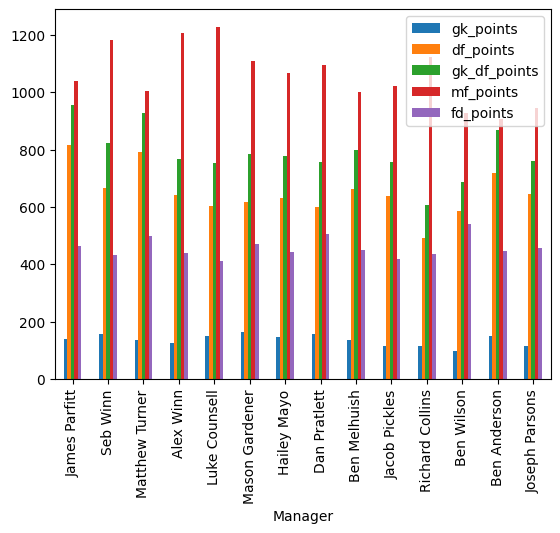

In [27]:
ppp_df.loc[
    :,
    [
        "Manager",
        "gk_points",
        "df_points",
        "gk_df_points",
        "mf_points",
        "fd_points",
    ],
].plot.bar("Manager")

<Axes: xlabel='Manager'>

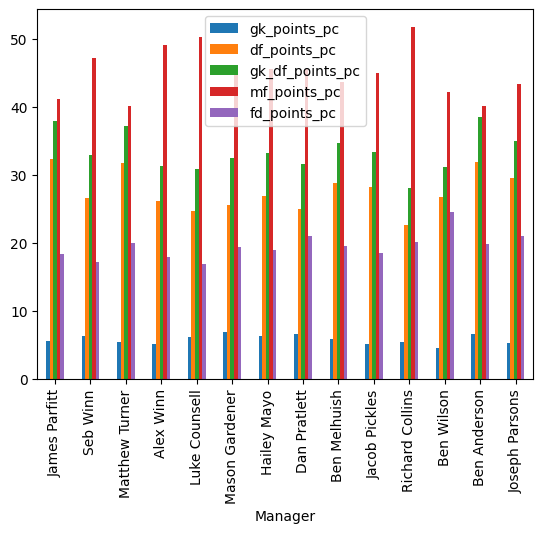

In [28]:
ppp_df.loc[
    :,
    [
        "Manager",
        "gk_points_pc",
        "df_points_pc",
        "gk_df_points_pc",
        "mf_points_pc",
        "fd_points_pc",
    ],
].plot.bar("Manager")

<Axes: xlabel='Manager'>

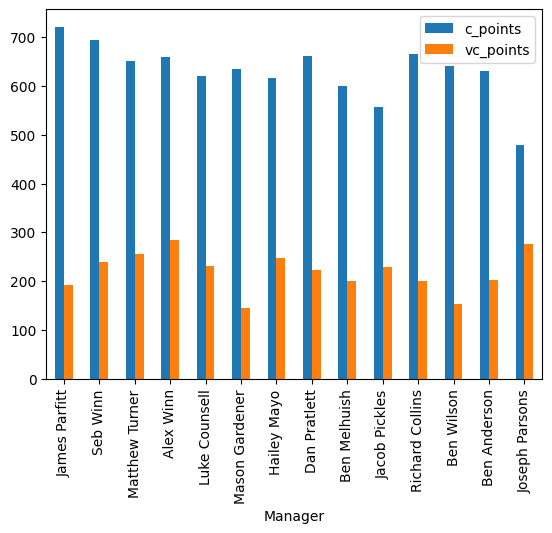

In [29]:
ppp_df.loc[
    :,
    [
        "Manager",
        "c_points",
        "vc_points",
    ],
].plot.bar("Manager")

<Axes: xlabel='Manager'>

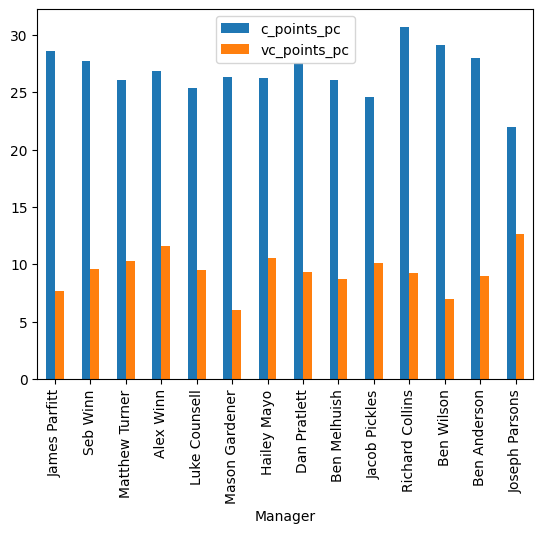

In [30]:
ppp_df.loc[
    :,
    [
        "Manager",
        "c_points_pc",
        "vc_points_pc",
    ],
].plot.bar("Manager")